<a id='top'></a><a name='top'></a>
# Chapter 8: Loopy (recurrent) neural networks (RNNs)

* [Introduction](#introduction)
* [8.0 Imports and Setup](#8.0)
* [8.1 Remembering with recurrent networks](#8.1)
    - [8.1.1 Backpropagation through time](#8.1.1)
    - [8.1.2 When do we update what?](#8.1.2)
    - [8.1.3 Recap](#8.1.3)
    - [8.1.4 There's always a catch](#8.1.4)
    - [8.1.5 Recurrent neural net with Keras](#8.1.5)
* [8.2 Putting things together](#8.2)
* [8.3 Let's get to learning our past selves](#8.3)
* [8.4 Hyperparameters](#8.4)
* [8.5 Predicting](#8.5)
    - [8.5.1 Statefulness](#8.5.1)
    - [8.5.2 Two-way street](#8.5.2)
    - [8.5.3 What is this thing?](#8.5.3)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Datasets

* aclImdb_v1.tar.gz: [script](#aclImdb_v1.tar.gz), [source](https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1)
* GoogleNews-vectors-negative300.bin.gz: [script](#GoogleNews-vectors-negative300.bin.gz), [source](https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz)


### Explore

* Creating memory in a neural net
* Building a recurrent neural net
* Data handling for RNNs
* Backpropagating through time (BPTT)


### Key points

* In natural language sequences (words or characters), what came before is important to your model's understanding of the sequence.
* Splitting a natural language statement along the dimension of time (tokens) can help your machine deepen its understanding of natural language.
* You can backpropagate errors in time (tokens), as well as in the layers of a deep learning network.
* Because RNNs are particularly deep neural nets, RNN gradients are particularly temperamental, and they may disappear or explode.
* Efficiently modeling natural language character sequences wasn't possible until recurrent neural nets were applied to the task.
* Weights in an RNN are adjusted in aggregate across time for a given sample.
* You can use different methods to examine the output of recurrent neural nets.
* You can model the natural language sequence in a document by passing the sequence of tokens through an RNN backward and forward simultaneously.

---
<a name='8.0'></a><a id='8.0'></a>
# 8.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_08.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
scrapy
watermark

Overwriting setup/requirements_08.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
if IS_COLAB:
    from sklearnex import patch_sklearn
    patch_sklearn()

In [10]:
%%writefile setup/chp08_imports.py
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import warnings
from pathlib import Path
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp08_imports.py


In [7]:
!isort setup/chp08_imports.py --sl
!cat setup/chp08_imports.py

Fixing /Users/gb/Desktop/examples/setup/chp08_imports.py
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import warnings
from pathlib import Path
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tqdm.auto import tqdm
from watermark import watermark


In [9]:
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import warnings
from pathlib import Path
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(42)
np.random.seed(42)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

seaborn   : 0.12.1
pandas    : 1.5.3
sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
matplotlib: 3.6.2
numpy     : 1.23.5



---
<a name='8.1'></a><a id='8.1'></a>
# 8.1 Remembering with recurrent networks
<a href="#top">[back to top]</a>

Problem: What is the basic characteristic of sequence in NLP? 

Idea: Words in a document are rarely completely independent of each other. Their occurrence influences or is influenced by occurrences of other words in a document. What came before is important to a model's understanding of the sequence, and to model relationships. 

Importance: We can a model a sequential relatinship via RNNs, which enables affecting state across time.

<a name='8.1.1'></a><a id='8.1.1'></a>
## 8.1.1 Backpropagation through time
<a href="#top">[back to top]</a>

Problem: What is mechanism for backpropagation through time?

Idea: These are the basic steps

* Break each data sample into tokens.
* Pass each token into feedforward net.
* Pass the output of each time step to the input of the same layer alongside the input from the next time step.
* Collect the output of the last time step and compare it to the label.
* Backpropagate the error through the whole graph, all the way back to the first input at time step 0.

<a name='8.1.2'></a><a id='8.1.2'></a>
## 8.1.2 When do we update what?
<a href="#top">[back to top]</a>

Problem: When do we update the weights in a RNN?

Idea: Weight corrections are calculated at each time step, but no immediately updated. 

Importance: In a feedforward, non-RNN network, all weight updates are calculated once all the gradients have been calculated for that input. In a RNN, the same holds, but we have to hold the updates until we go all the way back in time, to time step 0 for that particular input sample. The gradient calculations need to be based on the values that the weights had when they contributed that much to the error. 

<a name='8.1.3'></a><a id='8.1.3'></a>
## 8.1.3 Recap
<a href="#top">[back to top]</a>

Problem: What is the basic requirement for a RNN?

Idea: Essentially, a RNN is a feedforward network needs to have some concept of time, and a way to manage/maintain state of occurrences in that timeline.

<a name='8.1.4'></a><a id='8.1.4'></a>
## 8.1.4 There's always a catch
<a href="#top">[back to top]</a>

Problem: What is the biggest problem of a RNN?

Idea: The *vanishing gradient problem* and *exploding gradient problem*. In the first, the error signal dissipates with every computation of the gradient, whereas in the latter it grows. Essentially, the gradient may vanish or explode on the way to the last weight set.

Importance: This problem also applies to regular feed forward networks. However this problem is worsened in RNNs, since these tend to be much deeper, with sequences of tokens that can be hundreds long. 

<a name='8.1.5'></a><a id='8.1.5'></a>
## 8.1.5 Recurrent neural net with Keras
<a href="#top">[back to top]</a>

Problem: How to create a basic RNN with Keras?

Idea: These are the basic steps:

1. Preprocess dataset
2. Tokenize and vectorize dataset
3. Split into training and test datasets
4. Create a basic Sequential model with recurrent SimpleRNN layer
5. Add a Dropout layer
6. Compile and train the model

<a id='aclImdb_v1.tar.gz'></a><a name='aclImdb_v1.tar.gz'></a>
### Dataset: aclImdb_v1.tar.gz
<a href="#top">[back to top]</a>

In [10]:
data_imdb_file = "aclImdb_v1.tar.gz"
data_imdb_url = f"https://www.dropbox.com/s/yviic64qv84x73j/{data_imdb_file}?dl=1"
data_imdb_dir = Path("data/data_imdb")
data_imdb_src = data_imdb_dir / data_imdb_file
data_imdb_path = data_imdb_dir / "aclImdb"

print(f"""
data_imdb_file:\t{data_imdb_file}
data_imdb_url:\t{data_imdb_url}
data_imdb_dir:\t{data_imdb_dir}
data_imdb_src:\t{data_imdb_src}
data_imdb_path:\t{data_imdb_path}
""")


data_imdb_file:	aclImdb_v1.tar.gz
data_imdb_url:	https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1
data_imdb_dir:	data/data_imdb
data_imdb_src:	data/data_imdb/aclImdb_v1.tar.gz
data_imdb_path:	data/data_imdb/aclImdb



In [11]:
if not os.path.exists(data_imdb_dir):
    os.mkdir(data_imdb_dir)
    
if not data_imdb_src.is_file():
    print(f"Downloading {data_imdb_url} to {data_imdb_src}")
    subprocess.run(shlex.split(f"wget -q -O {data_imdb_src} {data_imdb_url}"))
    print("Done.")
else:
    print(f"{data_imdb_src} exists.")

data/data_imdb/aclImdb_v1.tar.gz exists.


In [12]:
!du -h {data_imdb_path}

 50M	data/data_imdb/aclImdb/aclImdb/test/neg
 50M	data/data_imdb/aclImdb/aclImdb/test/pos
121M	data/data_imdb/aclImdb/aclImdb/test
 50M	data/data_imdb/aclImdb/aclImdb/train/neg
201M	data/data_imdb/aclImdb/aclImdb/train/unsup
 50M	data/data_imdb/aclImdb/aclImdb/train/pos
365M	data/data_imdb/aclImdb/aclImdb/train
487M	data/data_imdb/aclImdb/aclImdb
487M	data/data_imdb/aclImdb


<a id='GoogleNews-vectors-negative300.bin.gz'></a><a name='GoogleNews-vectors-negative300.bin.gz'></a>
### Dataset: GoogleNews-vectors-negative300.bin.gz
<a href="#top">[back to top]</a>

In [13]:
data_gn_dir = 'data/data_word2vec'
if not os.path.exists(data_gn_dir):
    os.mkdir(data_gn_dir)

data_gn_file = 'GoogleNews-vectors-negative300.bin.gz'
data_gn_path = f"{data_gn_dir}/{data_gn_file}"
!wget -P {data_gn_dir} -O {data_gn_path} -nc "https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz/GoogleNews-vectors-negative300.bin.gz?dl=1"
!ls -l {data_gn_dir}

File ‘data/data_word2vec/GoogleNews-vectors-negative300.bin.gz’ already there; not retrieving.
total 3216888
-rw-r--r--  1 gb  staff  1647046227 Mar 25 12:29 GoogleNews-vectors-negative300.bin.gz


In [14]:
!du -h {data_gn_path}

1.5G	data/data_word2vec/GoogleNews-vectors-negative300.bin.gz


In [15]:
# Constants for IMDB training data and Word2vec data
TRAINING_DATA_N = 2_000 # ok: 1000, 2000 / 10_000 results in a crash

# Possible values:
# None
# 200_000 most common words from the Google News corpus
WORD_2_VEC_N = 200_000

In [16]:
def pre_process_data(filepath):
    """
    This is dependent on your training data source but we will try to generalize it as best as possible.
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')    
    pos_label = 1
    neg_label = 0
    
    dataset = []
    
    for i, filename in enumerate(glob.glob(os.path.join(positive_path, '*.txt'))):
        if i < TRAINING_DATA_N:
            with open(filename, 'r') as f:
                dataset.append((pos_label, f.read()))
        else:
            break
                
    for i, filename in enumerate(glob.glob(os.path.join(negative_path, '*.txt'))):
        if i < TRAINING_DATA_N:
            with open(filename, 'r') as f:
                dataset.append((neg_label, f.read()))
        else:
            break
            
    shuffle(dataset)
    
    return dataset

In [17]:
%%time
# Load GoogleNews Word2Vec vocabulary
word_vectors = KeyedVectors.load_word2vec_format(
    data_gn_path, 
    binary=True, 
    limit=WORD_2_VEC_N # 200_000
)

CPU times: user 5.47 s, sys: 500 ms, total: 5.97 s
Wall time: 6.92 s


In [18]:
# Listing 8.3 Data tokenizer + vectorizer
# Tokenize and vectorize the IMDB dataset using the Google Word2vec model
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])

            except KeyError:
                pass  # No matching token in the Google w2v vocab
            
        vectorized_data.append(sample_vecs)

    return vectorized_data

In [19]:
word_vectors["dog"][:5]

array([ 0.05126953, -0.02233887, -0.17285156,  0.16113281, -0.08447266],
      dtype=float32)

In [20]:
# Listing 8.4 Target unzipper
def collect_expected(dataset):
    """Peel off the target values from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

In [21]:
!du -h {data_imdb_path}/aclImdb/train

 50M	data/data_imdb/aclImdb/aclImdb/train/neg
201M	data/data_imdb/aclImdb/aclImdb/train/unsup
 50M	data/data_imdb/aclImdb/aclImdb/train/pos
365M	data/data_imdb/aclImdb/aclImdb/train


In [22]:
%%time
# Listing 8.5 Load and prepare the data
print("Preprocess training dataset")
dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")

print("Create vectorized data")
vectorized_data = tokenize_and_vectorize(dataset)

print("Preprocess target dataset")
expected = collect_expected(dataset)

Preprocess training dataset
Create vectorized data
Preprocess target dataset
CPU times: user 7.33 s, sys: 1.02 s, total: 8.35 s
Wall time: 11.4 s


In [23]:
print(len(dataset))
print(len(vectorized_data))
print(len(expected))

4000
4000
4000


In [24]:
%%time
split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

CPU times: user 86 µs, sys: 33 µs, total: 119 µs
Wall time: 125 µs


In [25]:
# Listing 8.6 Initialize your network parameters
maxlen = 400
batch_size = 32         # How many samples to show the net before backpropogating the error and updating the weights
embedding_dims = 300    # Length of the token vectors we will create for passing into the Convnet
epochs = 2

In [26]:
def pad_trunc(data, maxlen):
    """ For a given dataset pad with zero vectors or truncate to maxlen """
    new_data = []

    # Create a vector of 0's the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
 
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

In [27]:
%%time
# Listing 8.7 Load your test and training data
# This may require a lot of memory and crash Colab.
print("Prepare training and test splits")
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)
print("Done with padding")

Prepare training and test splits
Done with padding
CPU times: user 92.6 ms, sys: 11.3 ms, total: 104 ms
Wall time: 130 ms


In [28]:
print(len(x_train))
print(len(x_test))

3200
800


**Note**

Creating a huge Python list and then casting it to a Numpy array requires too much memory, and this crashes on Colab.

One response to create a list small enough so it doesn't exceed available memory.

Another is to create a numpy array without "casting" a list (or other iterable), by using one of the several methods defined by numpy itself that returns array:

    np.empty, np.zeros, np.ones, np.full 
    
These create arrays of given size with fixed values. However, the array size/shape must be known beforehand.

In [29]:
%%time
print("Reshaping training and test splits")
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)
print("Done")

Reshaping training and test splits
Done
CPU times: user 20.9 s, sys: 2.46 s, total: 23.4 s
Wall time: 28 s


In [30]:
print(type(x_train))
HR()
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

<class 'numpy.ndarray'>
----------------------------------------
x_train: (3200, 400, 300)
y_train: (3200,)
x_test: (800, 400, 300)
y_test: (800,)


In [31]:
%%time
# Listing 8.8 Initialize an empty Keras network
num_neurons = 50

print('Build model')
model = Sequential()

# Listing 8.9 Add a recurrent layer
model.add(SimpleRNN(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))

# Listing 8.10 Add a dropout layer
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model

Build model


2023-03-30 21:25:11.801882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 183 ms, sys: 82.6 ms, total: 266 ms
Wall time: 498 ms


---
<a name='8.2'></a><a id='8.2'></a>
# 8.2 Putting things together
<a href="#top">[back to top]</a>

Problem: What are the key points of this particular model?

Idea: This recurrent neural network is small, but we are learning 37,551 parameters. This is a lot of weights to update based on 20,000 training samples. 

In [32]:
# Listing 8.11 Compile your recurrent network
model.compile(
    'rmsprop',
    'binary_crossentropy',  
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 400, 50)           17550     
                                                                 
 dropout (Dropout)           (None, 400, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 37,551
Trainable params: 37,551
Non-trainable params: 0
_________________________________________________________________
None


---
<a name='8.3'></a><a id='8.3'></a>
# 8.3 Let's get to learning our past selves
<a href="#top">[back to top]</a>

Problem: What is the next step?

Idea: Use the .fit() method on this model.

In [33]:
%%time
# Listing 8.12 Train and save your model
print("Fitting model")
HR()
hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)

HR()
print("Done")

Fitting model
----------------------------------------
Epoch 1/2
100/100 [==============================] - 17s 153ms/step - loss: 0.7064 - accuracy: 0.5756 - val_loss: 0.7070 - val_accuracy: 0.6187
Epoch 2/2
100/100 [==============================] - 13s 128ms/step - loss: 0.4658 - accuracy: 0.7788 - val_loss: 0.5932 - val_accuracy: 0.6938
----------------------------------------
Done
CPU times: user 45.9 s, sys: 21.1 s, total: 1min 7s
Wall time: 35.8 s


In [34]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [35]:
print(hist.history['loss'])
HR()
print(hist.history['val_loss'])
HR()
print(hist.history['accuracy'])
HR()
print(hist.history['val_accuracy'])

[0.7064127326011658, 0.4658125340938568]
----------------------------------------
[0.7070186138153076, 0.5932104587554932]
----------------------------------------
[0.5756250023841858, 0.7787500023841858]
----------------------------------------
[0.6187499761581421, 0.6937500238418579]


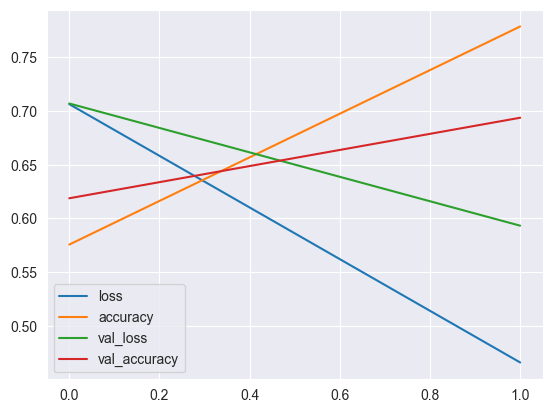

In [36]:
df = pd.DataFrame(hist.history)
df.plot(legend=True, grid=True)
plt.show()

In [37]:
data_root = 'models/model_simplernn'

if not os.path.exists(data_root):
    os.makedirs(data_root)

In [38]:
print("Saving model")
HR()

model_structure = model.to_json()

with open(f"{data_root}/simplernn_model1.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{data_root}/simplernn_weights1.h5")

print('Model saved.')

Saving model
----------------------------------------
Model saved.


In [39]:
!du -h {data_root}

556K	models/model_simplernn


---
<a name='8.4'></a><a id='8.4'></a>
# 8.4 Hyperparameters
<a href="#top">[back to top]</a>

Problem:

Idea:

In [40]:
# Listing 8.13 Model parameters
maxlen = 400
embedding_dims = 300
batch_size = 2
epochs = 1 # 2
num_neurons = 50

In [41]:
# Listing 8.14 Building a larger network

# Increase num_neurons from 50 to 100
num_neurons = 100

model = Sequential()
model.add(SimpleRNN(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(
    'rmsprop',
    'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 400, 100)          40100     
                                                                 
 dropout_1 (Dropout)         (None, 400, 100)          0         
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 40001     
                                                                 
Total params: 80,101
Trainable params: 80,101
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Listing 8.15 Training your larger network
hist = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

1600/1600 [==============================] - 146s 90ms/step - loss: 2.8076 - accuracy: 0.5344 - val_loss: 1.7773 - val_accuracy: 0.6075


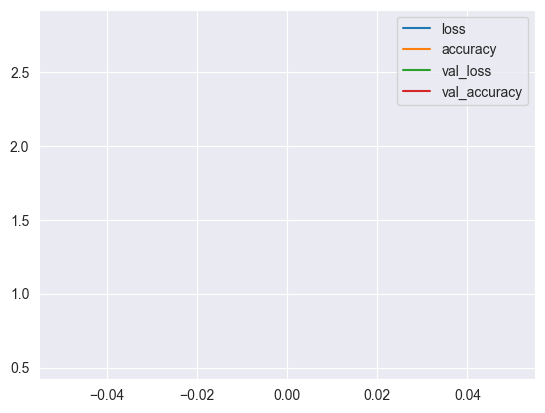

In [43]:
df = pd.DataFrame(hist.history)
df.plot(legend=True, grid=True)
plt.show()

In [44]:
print("Saving model2")
HR()

model_structure = model.to_json()

with open(f"{data_root}/simplernn_model2.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{data_root}/simplernn_weights2.h5")

print('Model saved.')

Saving model2
----------------------------------------
Model saved.


---
<a name='8.5'></a><a id='8.5'></a>
# 8.5 Predicting
<a href="#top">[back to top]</a>

Problem:

Idea:

In [45]:
# Listing 8.16 Crummy weather sentiment
sample_1 = """I'm hate that the dismal weather that had me down for so long, 
when will it break! Ugh, when does happiness return?  
The sun is blinding and the puffy clouds are too thin.  
I can't wait for the weekend."""

In [46]:
with open(f"{data_root}/simplernn_model1.json", "r") as json_file:
    json_string = json_file.read()
    
model = model_from_json(json_string)
model.load_weights(f"{data_root}/simplernn_weights1.h5")

In [47]:
# We pass a dummy value in the first element of the tuple just because our helper expects it from the way processed the initial data.  That value won't ever see the network, so it can be whatever.
vec_list = tokenize_and_vectorize([(1, sample_1)])

# Tokenize returns a list of the data (length 1 here)
test_vec_list = pad_trunc(vec_list, maxlen)

test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

In [48]:
y_pred = model.predict(test_vec)
print(y_pred)

1/1 [==============================] - 0s 475ms/step
[[0.60227954]]


In [49]:
# 0 = negative review, 1 = positive review
sentiment_imdb = []
sentiment_imdb.append('Negative Sentiment')
sentiment_imdb.append('Positive Sentiment')

In [50]:
# If model is binary classification, eg  sigmoid last-layer activation
res01 = (np.argmax(y_pred > 0.5))
print(res01)
sentiment_imdb[res01]

0


'Negative Sentiment'

In [51]:
# If model is  multi-class classification, eg softmax last-layer activation
res02 = (np.argmax(y_pred, axis=-1))[0] # This returns a list, so we have to extract to int
print(res02)
sentiment_imdb[res02]

0


'Negative Sentiment'

<a name='8.5.1'></a><a id='8.5.1'></a>
## 8.5.1 Statefulness
<a href="#top">[back to top]</a>

Problem: How to retain information from one input sample to the next, not just one-time step (token) to the next within a single sample? In other words, how to retain information beyond a given training step?

Idea: Keras provides the argument `stateful`. The default is `False`, but when set to `True` when using the `SimpleRNN` layer, the last sample's output passes into itself at the next time step, along with the first token input.

Importance: Keeping state this way can be useful when modeling a large document that has been split into paragraphs or sentences for processing. It can also be useful to model the meaning of an entire corpus of related documents. 

<a name='8.5.2'></a><a id='8.5.2'></a>
## 8.5.2 Two-way street
<a href="#top">[back to top]</a>

Problem: How to exploit sequences in both directions?

Idea: Use bidirectional RNNs. Keras has the layer wrapper `Bidirectional` that automatically flips around inputs and outpus to assemble a bi-directinoal RNN. 

In [52]:
# Listing 8.17 Build a Bidirectional recurrent network
num_neurons = 10
maxlen = 100
embedding_dims = 300

model = Sequential()

model.add(
    Bidirectional(
        SimpleRNN(
            num_neurons,
            return_sequences=True
        ), 
        input_shape=(maxlen, embedding_dims)
    )
)

model.add(Dense(1, activation='sigmoid'))
model.compile(
    'rmsprop',
    'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 20)          6220      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 100, 1)            21        
                                                                 
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Listing 8.15 Training your larger network

# # This will likely crash on Colab, since it requires more memory than available
# model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_test, y_test),
#     verbose=1
# )

<a name='8.5.3'></a><a id='8.5.3'></a>
## 8.5.3 What is this thing?
<a href="#top">[back to top]</a>

Problem: What is significance of the vector in-between the last Dense layer and the previous Recurrent layer?

Idea: This is analogous to the *thought vector* seen in a CNN model. It is an encoding of the sequence of tokens. 

Importance: This vector only encodes the thought of sentences in relation to the label the network is trained on. But in terms of NLP, it is a useful step toward encoding higher order concepts into a vector computationally.